# Local coupling via Spherical Harmonics

This notebook takes a tour through the spherical harmonic transform for implementing local coupling in neural fields:

- [x] Spherical grid & distances
- [ ] Basic use of transforms both SHTns and NumPy/Jax implementation
- [x] Examining the effective kernel
- [x] Designing a custom kernel
- [ ] Deriving a sparse matrix from spherical grid
- [ ] Autograd for SHT coupling
- [ ] Batching SHT coupling
- [ ] Performance

In [7]:
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2
%pylab inline
import numpy as np
import tqdm
import shtns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
import nfjax.shtlc as lc

## Setup the grid

To make efficient use of the transforms, a regular grid is used for the whole sphere, defined by 

- nlat - the number of latitudes
- nlon - the number of longitudes

On this grid, the number of harmonics used is `lmax`.

In [57]:
sht, phi, theta, gw = lc.make_grid_shtns(lmax=31, nlat=32, nlon=64, D=-1e-4)
ds = lc.grid_pairwise_distance(theta, phi)

## S^2 default kernel

(Text(0.5, 0, 'Distance (cm)'),
 Text(0, 0.5, 'SHT ampl'),
 Text(0.5, 1.0, 'Default kernel (D*l*(l+1))'))

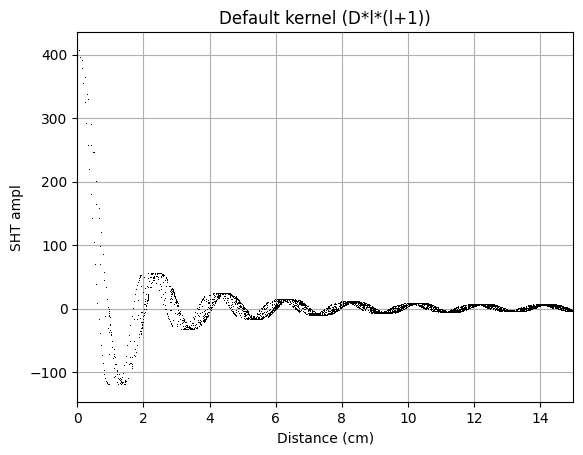

In [17]:
x0 = lc.randn_relaxed(sht)
dfs = lc.kernel_estimate_shtns(sht, lc.kernel_diff(0.1, sht.l), x0)
plot(ds.ravel()[::5]*lc.rad_to_cm, dfs.ravel()[::5], ',k')
xlim([0, 15]); grid(1)
xlabel('Distance (cm)'), ylabel('SHT ampl'), title("Default kernel (D*l*(l+1))")

The default kernel is very extended.  Can we design a better kernel?

## S^2 arbitrary kernel

We can design our our kernels by evaluating a kernel over distances from the origin and transforming to SH

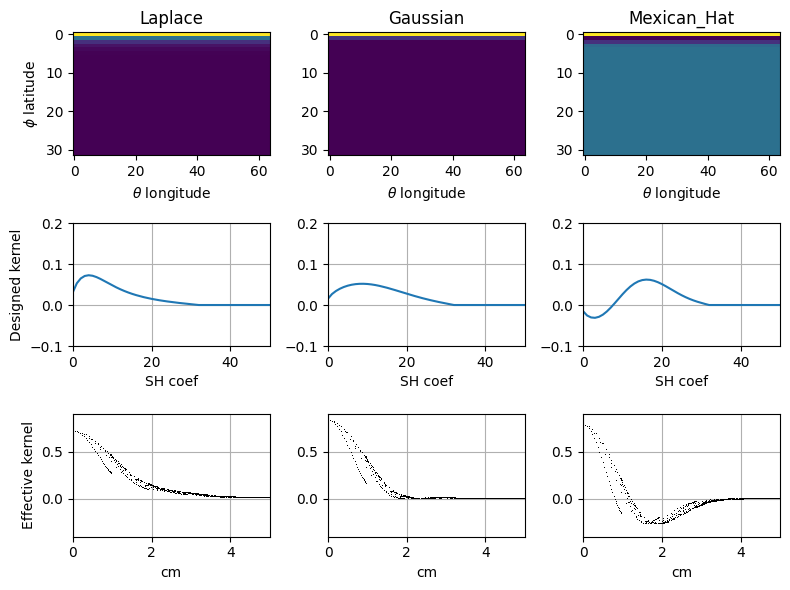

In [56]:
figure(figsize=(8,6))
for i, (name, size) in enumerate(zip('laplace gaussian mexican_hat'.split(' '), (0.1, 0.01, 0.1))):
    
    # design kernel & compute effect
    k = getattr(lc, f'kernel_{name}')(sht, theta, phi, size)
    K = lc.kernel_sh_normalized(sht, k)
    ef = lc.kernel_estimate_shtns(sht, lc.kernel_conv_prep(sht, k), x0)
    
    subplot(3, 3, i + 1)
    imshow(k, aspect='auto'), xlabel(r'$\theta$ longitude'), title(name.title())
    if i==0: ylabel(r'$\phi$ latitude')
    
    subplot(3, 3, i + 4), xlabel('SH coef')
    plot(K.real), xlim([0, 50]), ylim([-0.1,0.2]), grid(1)
    if i==0: ylabel('Designed kernel')
    
    subplot(3, 3, i + 7),
    plot(ds.ravel()[::5]*lc.rad_to_cm, ef.ravel()[::5], ',k')
    xlim([0,5]), ylim([-0.4,0.9]), grid(1), xlabel('cm'), ylabel('')
    if i==0: ylabel('Effective kernel')

tight_layout()

The kernels are normalized by area: the Laplacian kernel falls off, so it has lower max amplitude.  The Gaussian requires a smaller size value than the other two.